# NLP mini-pipeline: tokenization -> TF-IDF -> classification -> evaluation

# 1. Setup

In [32]:
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)

# 2. Tiny Offline Dataset & Basic Tokenization

In [4]:
docs_pos = [
    "I loved this movie, absolutely fantastic performances!",
    "What a wonderful experience, the plot was engaging.",
    "Great acting and stunning visuals. Highly recommend.",
    "This film is brilliant; beautiful story and soundtrack.",
    "An excellent and heartwarming movie. I enjoyed it."
]

docs_neg = [
    "I hated this movie, a complete waste of time.",
    "Terrible acting and a boring plot. Not recommended.",
    "What an awful experience, I fell asleep twice.",
    "This film is bad; messy story and poor dialogue.",
    "A disappointing and painful watch."
]

In [9]:
X_text = docs_pos + docs_neg

In [6]:
y = np.array([1] * len(docs_pos) + [0] * len(docs_neg))

仅保留 ASCII 英文字母（ASCII letters）；数字、符号、下划线、连字符、撇号、非英语字母都会被丢弃或切断。

* "can't" → ["can", "t"]（撇号被切断）

* "e-mail" → ["e", "mail"]（连字符被切断）

* "Café" → ["caf"]（é 不是 ASCII 字母）

* "中文ABC123" → ["abc"]（小写后变 "abc"；数字与中文被忽略）

In [10]:
def simple_tokenize(s):
    #lowercase + keep alphabetic tokens only
    return re.findall(r"[a-zA-Z]+", s.lower());

In [12]:
for s in X_text[:2]:
    print("TEXT:", s)
    print("TOKENS:", simple_tokenize(s), "\n")

TEXT: I loved this movie, absolutely fantastic performances!
TOKENS: ['i', 'loved', 'this', 'movie', 'absolutely', 'fantastic', 'performances'] 

TEXT: What a wonderful experience, the plot was engaging.
TOKENS: ['what', 'a', 'wonderful', 'experience', 'the', 'plot', 'was', 'engaging'] 



# 3. TF-IDF Vectorization

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_text, y, test_size=0.4, random_state=42, stratify=y)

In [18]:
# TfidfVectorizer: transforms raw text → TF-IDF features
# TfidfVectorizer：把原始文本转换成 TF-IDF 特征
# key params / 关键参数:
# - tokenizer / 分词器（这里用默认英文分词，你也可以用 simple_tokenize）
# - ngram_range / n-gram 范围（(1,2) 会使用 uni-gram + bi-gram）
# - min_df / 低频阈值（过滤只出现过一次的词，减少噪声）

vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),   # use unigrams + bigrams / 一元 + 二元短语
    min_df=1,            # tiny data, keep as 1 / 小数据保留全部词
    stop_words='english' # remove common stopwords / 去常见停用词
    # tokenizer=simple_tokenize  # (optional) use custom tokenizer / 可切换自定义分词器
)

In [19]:
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

In [20]:
print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Vocab size:", len(vectorizer.vocabulary_))

Train shape: (6, 47)
Val   shape: (4, 47)
Vocab size: 47


In [21]:
X_train

<6x47 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

In [22]:
vocab = vectorizer.vocabulary_
print("Vocab size:", len(vocab))

# 随机看前 20 个条目（无序）
import itertools
print(list(itertools.islice(vocab.items(), 20)))

Vocab size: 47
[('film', 21), ('brilliant', 11), ('beautiful', 7), ('story', 35), ('soundtrack', 34), ('film brilliant', 22), ('brilliant beautiful', 12), ('beautiful story', 8), ('story soundtrack', 36), ('disappointing', 13), ('painful', 27), ('watch', 44), ('disappointing painful', 14), ('painful watch', 28), ('terrible', 39), ('acting', 0), ('boring', 9), ('plot', 29), ('recommended', 33), ('terrible acting', 40)]


In [23]:
# 按列号从小到大查看（与矩阵列对齐）
vocab_sorted = sorted(vocab.items(), key=lambda kv: kv[1])  # [(token, col_idx), ...]
print(vocab_sorted[:20])   # 最靠前的 20 个特征
print(vocab_sorted[-20:])  # 最靠后的 20 个特征（最大列号）

[('acting', 0), ('acting boring', 1), ('acting stunning', 2), ('asleep', 3), ('asleep twice', 4), ('awful', 5), ('awful experience', 6), ('beautiful', 7), ('beautiful story', 8), ('boring', 9), ('boring plot', 10), ('brilliant', 11), ('brilliant beautiful', 12), ('disappointing', 13), ('disappointing painful', 14), ('engaging', 15), ('experience', 16), ('experience fell', 17), ('experience plot', 18), ('fell', 19)]
[('painful', 27), ('painful watch', 28), ('plot', 29), ('plot engaging', 30), ('plot recommended', 31), ('recommend', 32), ('recommended', 33), ('soundtrack', 34), ('story', 35), ('story soundtrack', 36), ('stunning', 37), ('stunning visuals', 38), ('terrible', 39), ('terrible acting', 40), ('twice', 41), ('visuals', 42), ('visuals highly', 43), ('watch', 44), ('wonderful', 45), ('wonderful experience', 46)]


In [24]:
import numpy as np

idf = vectorizer.idf_  # shape (V,)
feature_names = vectorizer.get_feature_names_out()

# 稀有（idf 最大）的前 20 个
top_idf_idx = np.argsort(-idf)[:20]
for j in top_idf_idx:
    print(f"{feature_names[j]:30s} idf={idf[j]:.3f}")

# 最常见（idf 最小）的前 20 个
low_idf_idx = np.argsort(idf)[:20]
for j in low_idf_idx:
    print(f"{feature_names[j]:30s} idf={idf[j]:.3f}")

great                          idf=2.253
highly                         idf=2.253
highly recommend               idf=2.253
painful                        idf=2.253
painful watch                  idf=2.253
plot engaging                  idf=2.253
plot recommended               idf=2.253
recommend                      idf=2.253
recommended                    idf=2.253
soundtrack                     idf=2.253
story                          idf=2.253
story soundtrack               idf=2.253
stunning                       idf=2.253
stunning visuals               idf=2.253
terrible                       idf=2.253
terrible acting                idf=2.253
twice                          idf=2.253
visuals                        idf=2.253
visuals highly                 idf=2.253
watch                          idf=2.253
acting                         idf=1.847
plot                           idf=1.847
experience                     idf=1.847
highly recommend               idf=2.253
painful         

In [25]:
i = 0
row = X_train[i]
print(row.indices[:10], row.data[:10])  

[21 11  7 35 34 22 12  8 36] [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333]


In [27]:
row.shape

(1, 47)

In [28]:
row.indices

array([21, 11,  7, 35, 34, 22, 12,  8, 36], dtype=int32)

In [29]:
row.data

array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333])

In [30]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:10])

['acting' 'acting boring' 'acting stunning' 'asleep' 'asleep twice'
 'awful' 'awful experience' 'beautiful' 'beautiful story' 'boring']


In [31]:
y_train

array([1, 0, 0, 1, 1, 0])

# 4. Train Two Classifiers (NB and Logistic)

In [33]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [34]:
logreg = LogisticRegression(max_iter=200, solver="liblinear")
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,200
,multi_class,'deprecated'


# 5. Evaluate


=== MultinomialNB ===
Accuracy: 0.2500

Classification report: 
               precision    recall  f1-score   support

         neg       0.33      0.50      0.40         2
         pos       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4

Confuction matrix: 
 [[1 1]
 [2 0]]


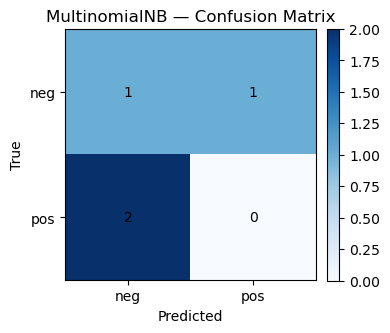


=== LogisticRegression ===
Accuracy: 0.2500

Classification report: 
               precision    recall  f1-score   support

         neg       0.33      0.50      0.40         2
         pos       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4

Confuction matrix: 
 [[1 1]
 [2 0]]


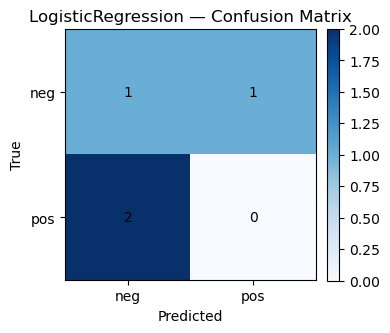

In [37]:
def evaluate_and_report(model, name):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"\nClassification report: \n {classification_report(y_val, y_pred, target_names=['neg', 'pos'])}")
    cm = confusion_matrix(y_val, y_pred, labels=[0,1])
    print(f"Confuction matrix: \n {cm}")

    fix, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"{name} — Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["neg","pos"]); ax.set_yticklabels(["neg","pos"])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

evaluate_and_report(nb,     "MultinomialNB")
evaluate_and_report(logreg, "LogisticRegression")